In [4]:
from vtl.Readfile import Readfile
from spec_id import Analyze_Stack_avgage, Error,Oldest_galaxy, Gen_spec, \
    Combine_1D_parameters, Stack,Median_model, Median_w_Error
from astropy.table import Table
from astropy.io import fits
from scipy.interpolate import interp1d
from scipy.ndimage import interpolation
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from glob import glob
import seaborn as sea
import numpy as np
import pandas as pd
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colors = [(0,i,i,i) for i in np.linspace(0,1,3)]
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [4]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)

tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [68]:
galDB

,gids,ids,ra,dec,hi_res_specz,Z,Z_-_sig,Z_+_sig,t,t_-_sig,t_+_sig,lmass
43,n14713,14713,189.236333,62.214608,1.232,0.019,0.012,0.008,3.1,0.903,0.541,10.56
49,n16758,16758,189.162357,62.224840,1.014,0.021,0.002,0.002,5.5,0.470,0.125,10.83
50,n17070,17070,189.268086,62.226445,1.192,0.017,0.007,0.006,2.5,0.732,0.998,10.92
58,n19442,19442,189.123036,62.237460,1.101,0.015,0.010,0.010,2.9,1.033,0.818,10.10
61,n21156,21156,189.239409,62.247548,1.251,0.015,0.005,0.006,2.6,0.524,0.622,11.16
62,n21427,21427,189.368121,62.247344,1.514,0.020,0.009,0.007,2.8,0.779,0.533,10.73
69,n23435,23435,189.338306,62.256571,1.134,0.015,0.007,0.008,3.7,0.907,0.779,10.27
86,n32566,32566,189.161280,62.307577,1.150,0.020,0.008,0.007,2.7,1.054,0.919,10.61
96,n34694,34694,189.147840,62.323647,1.145,0.014,0.005,0.006,3.1,0.671,1.048,10.94
107,n37686,37686,189.274474,62.360820,1.258,0.016,0.003,0.003,3.6,0.598,0.548,10.89


#UVJ plot

In [15]:
###DATA 
uvjDB = pd.read_pickle('../data/uvj_db.pkl')
uvjSDB = uvjDB[uvjDB['IN_SAMP'] == True]
uvjSuDB = uvjSDB[uvjSDB['(U-V)'] < 1.75]

In [21]:
###PLOTS
%matplotlib inline

# plt.figure(figsize=[10,10])
# plt.plot(uvjDB['(V-J)'],uvjDB['(U-V)'],'o',color='#127794', alpha=.5,ms=3, label = 'Star Forming')
# plt.plot(uvjDB['(V-J)'][uvjDB['Q/S'] == 'q'],uvjDB['(U-V)'][uvjDB['Q/S'] == 'q'],'o',color='#E81524', alpha=.5,ms=3, label = 'Quiscent')
# plt.plot(uvjDB['(V-J)'][uvjDB['IN_SAMP'] == True],uvjDB['(U-V)'][uvjDB['IN_SAMP'] == True],'d',color='#93000B',ms=10, label = 'Selected Sample')
# plt.plot([0,.9],[1.382,1.382],'k',lw=.9)
# plt.plot([1.65,1.65],[2.045,2.5],'k',lw=.9)
# plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9)
# plt.axis([0,2.5,.5,2.5])
# plt.legend(loc=2,fontsize=23)
# plt.xlabel('(V-J)',fontsize=30)
# plt.ylabel('(U-V)',fontsize=30)
# plt.tick_params(axis='both', which='major', labelsize=23)
# plt.minorticks_on()
# plt.gcf().subplots_adjust(bottom=0.16)
# # plt.show()
# plt.savefig('../plots/uvj_plot_6-28.png')
# plt.close()

plt.figure(figsize=[10,10])
sea.kdeplot(uvjDB['(V-J)'],uvjDB['(U-V)'],shade=False,cmap=cmap)
for i in uvjSuDB.index:
    plt.plot(uvjSuDB['(V-J)'][i],uvjSuDB['(U-V)'][i],'o',ms=5, label = i)
# plt.plot(uvjSDB['(V-J)'],uvjSDB['(U-V)'],'o',color='#93000B',ms=5, label = 'Selected Sample')
plt.plot([0,.9],[1.382,1.382],'k',lw=.9)
plt.plot([1.65,1.65],[2.045,2.5],'k',lw=.9)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9)
plt.axis([0,2.5,.5,2.5])
# plt.legend(loc=2,fontsize=23)
plt.legend()
plt.xlabel('(V-J)',fontsize=30)
plt.ylabel('(U-V)',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.show()
# plt.savefig('../plots/uvj_kde_plot_6-28.png')
plt.close()

#Example Spectra and Best Fit

In [37]:
###DATA
spec = Gen_spec(galDB['gids'][220], galDB['hi_res_specz'][220])
bftau = Median_model(galDB['gids'][220], galDB['hi_res_specz'][220], galDB['Z'][220], galDB['t'][220], tau)
spec.Sim_spec(galDB['Z'][220],galDB['t'][220],bftau)

../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


In [39]:
###PLOT
%matplotlib inline

sea.set_style( {"xtick.major.size": 8, "ytick.major.size": 8,
                "xtick.minor.size": 5, "ytick.minor.size": 5})
plt.figure(figsize=(15,7))
plt.errorbar(spec.gal_wv_rf,spec.gal_fl*1E18,spec.gal_er*1E18,fmt='o',color='#2e4473',ms=5,label = 'Galaxy Spectra')
plt.plot(spec.gal_wv_rf,spec.fl*1E18, color='#81161B',
         label='Best fit\nZ/Z$_\odot$=%s,\nt=%s Gyrs' % (np.round(galDB['Z'][220]/0.019,2),galDB['t'][220]))
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(5120, 5240, color='k', alpha=.1)
plt.text(3900,5.6,'Ca HK',fontsize=25)
plt.text(4080,5.6,'H$\delta$',fontsize=25)
plt.text(4280,5.6,'G+H$\gamma$',fontsize=25)
plt.text(4830,5.6,'H$\\beta$',fontsize=25)
plt.text(5160,5.6,'Mgb',fontsize=25)
plt.xlim(3900,5600)
plt.ylim(0,5.5)
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\AA$)',size=35)
plt.xlabel('Restframe Wavelength ($\AA$)',size=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(loc=4,fontsize=25)
plt.minorticks_on()
# plt.show()
plt.savefig('../plots/s39170_spec_6-2.png')
plt.close()

#Age Vs Redshift - 3 feat groups

In [5]:
"""DATA"""
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
mzDB = mzDB.query('ids != 14713 and ids != 38126')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

# Pl,Pm,Ph = np.ones([3,len(age)])
Pl,Pm,Ph,Puh = np.ones([4,len(age)])

for i in lzDB.index:
    t,Pt = np.load('../chidat/%s_t_pos.npy' % lzDB['gids'][i])
    Pl = Pl * Pt
    
for i in mzDB.index:
    t,Pt = np.load('../chidat/%s_t_pos.npy' % mzDB['gids'][i])
    Pm = Pm * Pt
    
for i in hzDB.index:
    t,Pt = np.load('../chidat/%s_t_pos.npy' % hzDB['gids'][i])
    Ph = Ph * Pt
    
for i in uhzDB.index:
    t,Pt = np.load('../chidat/%s_t_pos.npy' % uhzDB['gids'][i])
    Puh = Puh * Pt
    
Pl /= np.trapz(Pl,age)
Pm /= np.trapz(Pm,age)
Ph /= np.trapz(Ph,age)
Puh /= np.trapz(Puh,age)

lmed,ller,lher=Median_w_Error(Pl,age)
mmed,mler,mher=Median_w_Error(Pm,age)
hmed,hler,hher=Median_w_Error(Ph,age)
uhmed,uhler,uhher=Median_w_Error(Puh,age)

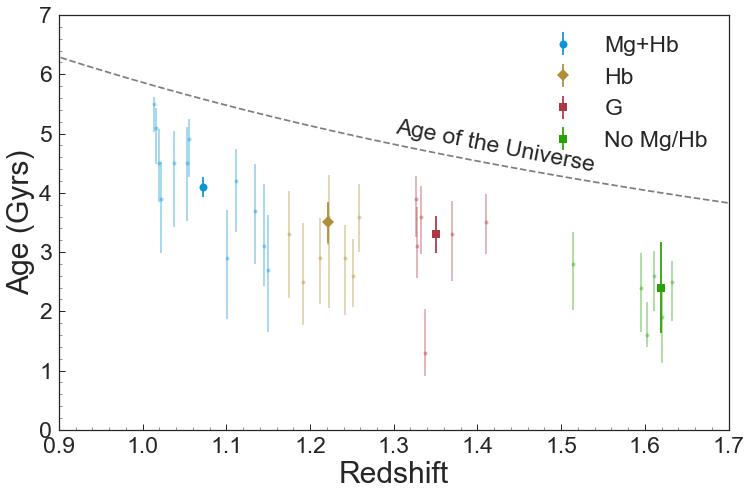

In [6]:
###PLOT
%matplotlib inline

lt=np.array(lzDB['t'])
mt=np.array(mzDB['t'])
ht=np.array(hzDB['t'])
uht=np.array(uhzDB['t'])

z=np.linspace(0,2,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[12,8])
currentAxis = plt.gca()
plt.plot(z,ages,'k--',alpha=.5)

plt.errorbar(lzDB['hi_res_specz'],lt,yerr=[lzDB['t_-_sig'],lzDB['t_+_sig']],color='#0D94D5',alpha=.4,ms=4,fmt='o')
plt.errorbar(mzDB['hi_res_specz'],mt,yerr=[mzDB['t_-_sig'],mzDB['t_+_sig']],color='#B18F3A',alpha=.4,ms=4,fmt='o')
plt.errorbar(hzDB['hi_res_specz'],ht,yerr=[hzDB['t_-_sig'],hzDB['t_+_sig']],color='#AB3843',alpha=.4,ms=4,fmt='o')
plt.errorbar(uhzDB['hi_res_specz'],uht,yerr=[uhzDB['t_-_sig'],uhzDB['t_+_sig']],color='#2AA104',alpha=.4,ms=4,fmt='o')

plt.errorbar(np.mean(lzDB['hi_res_specz']),lmed,yerr=[[ller,lher]], color='#0D94D5',ms=8,fmt='o',label='Mg+Hb')
plt.errorbar(np.mean(mzDB['hi_res_specz']),mmed,yerr=[[mler,mher]], color='#B18F3A',ms=8,fmt='D',label='Hb')
plt.errorbar(np.mean(hzDB['hi_res_specz']),hmed,yerr=[[hler,hher]], color='#AB3843',ms=8,fmt='s',label='G')
plt.errorbar(np.mean(uhzDB['hi_res_specz']),uhmed,yerr=[[uhler,uhher]], color='#2AA104',ms=8,fmt='s',label='No Mg/Hb')

plt.axis([0.9,1.7,0,7])
plt.xlabel('Redshift',size=30)
plt.ylabel('Age (Gyrs)',size=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.text(1.3,5.,'Age of the Universe',rotation=-11,fontsize=23)
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=23)
plt.show()
# plt.savefig('../plots/agevz_featgroup_7-2.png')
plt.close()

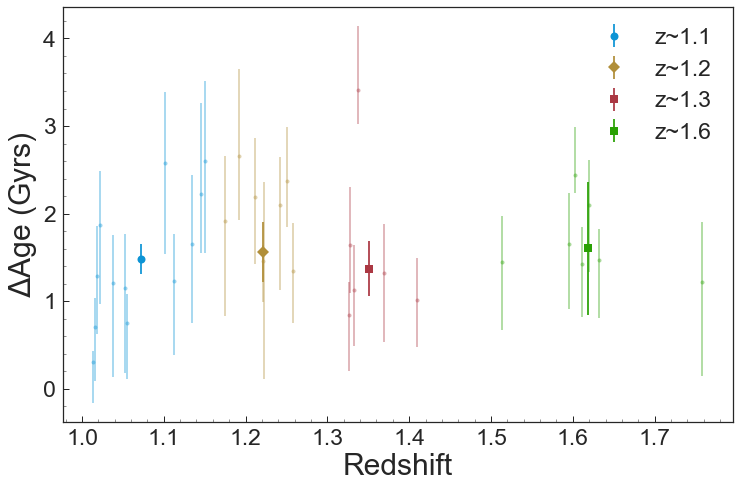

In [8]:
###PLOT
%matplotlib inline

lt=np.array(lzDB['t'])
mt=np.array(mzDB['t'])
ht=np.array(hzDB['t'])
uht=np.array(uhzDB['t'])

z=np.linspace(0,2,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[12,8])
currentAxis = plt.gca()

plt.errorbar(lzDB['hi_res_specz'], Oldest_galaxy(lzDB['hi_res_specz']) - lt,
             yerr=[lzDB['t_-_sig'],lzDB['t_+_sig']],color='#0D94D5',alpha=.4,ms=4,fmt='o')
plt.errorbar(mzDB['hi_res_specz'],Oldest_galaxy(mzDB['hi_res_specz']) - mt,
             yerr=[mzDB['t_-_sig'],mzDB['t_+_sig']],color='#B18F3A',alpha=.4,ms=4,fmt='o')
plt.errorbar(hzDB['hi_res_specz'],Oldest_galaxy(hzDB['hi_res_specz']) - ht,
             yerr=[hzDB['t_-_sig'],hzDB['t_+_sig']],color='#AB3843',alpha=.4,ms=4,fmt='o')
plt.errorbar(uhzDB['hi_res_specz'],Oldest_galaxy(uhzDB['hi_res_specz']) - uht,
             yerr=[uhzDB['t_-_sig'],uhzDB['t_+_sig']],color='#2AA104',alpha=.4,ms=4,fmt='o')

plt.errorbar(np.mean(lzDB['hi_res_specz']), Oldest_galaxy(np.mean(lzDB['hi_res_specz'])) - lmed,
             yerr=[[ller,lher]], color='#0D94D5',ms=8,fmt='o',label='z~1.1')
plt.errorbar(np.mean(mzDB['hi_res_specz']), Oldest_galaxy(np.mean(mzDB['hi_res_specz'])) - mmed,
             yerr=[[mler,mher]], color='#B18F3A',ms=8,fmt='D',label='z~1.2')
plt.errorbar(np.mean(hzDB['hi_res_specz']), Oldest_galaxy(np.mean(hzDB['hi_res_specz'])) - hmed,
             yerr=[[hler,hher]], color='#AB3843',ms=8,fmt='s',label='z~1.3')
plt.errorbar(np.mean(uhzDB['hi_res_specz']), Oldest_galaxy(np.mean(uhzDB['hi_res_specz'])) - uhmed,
             yerr=[[uhler,uhher]], color='#2AA104',ms=8,fmt='s',label='z~1.6')

# plt.axis([0.9,1.7,0,7])
plt.xlabel('Redshift',size=30)
plt.ylabel('$\Delta$Age (Gyrs)',size=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=23)
plt.show()
# plt.savefig('../plots/agevz_featgroup_7-2.png')
plt.close()

#Mass Metallcity - feat group

In [23]:
"""DATA"""
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
mzDB = mzDB.query('ids != 14713 and ids != 38126')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

# Pl,Pm,Ph = np.ones([3,len(metal)])
Pl,Pm,Ph,Puh = np.ones([4,len(metal)])

for i in lzDB.index:
    Z,PZ = np.load('../chidat/%s_Z_pos.npy' % lzDB['gids'][i])
    Pl = Pl * PZ
    
for i in mzDB.index:
    Z,PZ = np.load('../chidat/%s_Z_pos.npy' % mzDB['gids'][i])
    Pm = Pm * PZ
    
for i in hzDB.index:
    Z,PZ = np.load('../chidat/%s_Z_pos.npy' % hzDB['gids'][i])
    Ph = Ph * PZ
    
for i in uhzDB.index:
    Z,PZ = np.load('../chidat/%s_Z_pos.npy' % uhzDB['gids'][i])
    Puh = Puh * PZ
    
Pl /= np.trapz(Pl,metal)
Pm /= np.trapz(Pm,metal)
Ph /= np.trapz(Ph,metal)
Puh /= np.trapz(Puh,metal)

lmed,ller,lher=Median_w_Error(Pl,metal)
mmed,mler,mher=Median_w_Error(Pm,metal)
hmed,hler,hher=Median_w_Error(Ph,metal)
uhmed,uhler,uhher=Median_w_Error(Puh,metal)

logm,gmetal=Readfile('../data/Gallazzi_12.dat',0)
cvx,cvy=Readfile('../data/Gallazzi_12_line.dat',0)
cv1x,cv1y=Readfile('../data/gallazzi_points_curve1.dat',0)

In [24]:
###PLOT
%matplotlib inline

plt.figure(figsize=[12,8])
currentAxis = plt.gca()

####gallazzi points
plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.3,markersize=4)#, label='SDSS')
# sdss=plt.axhline(y=5,linestyle='--',color='k',alpha=.5)
plt.plot(cvx,cvy,zorder=2,color='k',alpha=.3,ms=4)#, label='Gallazzi+14 best fit line')
# galbf=plt.axhline(y=5,color='k',alpha=.5)
plt.plot(logm,gmetal,'o',zorder=3,color='k',alpha=.3,markersize=4)#,label='Gallazzi+14,z=0.7')

#####single galaxy points

lZ=np.array(lzDB['Z'])
mZ=np.array(mzDB['Z'])
hZ=np.array(hzDB['Z'])
uhZ=np.array(uhzDB['Z'])

l1= np.append(lZ,mZ)
l2= np.append(hZ,uhZ)
L = np.append(l1,l2)

m1= np.append(lzDB['lmass'],mzDB['lmass'])
m2= np.append(hzDB['lmass'],uhzDB['lmass'])
ML= np.append(m1,m2)

pars = np.polyfit(ML,np.log10(L/0.019),deg=1)
lfit = np.polyval(pars,np.arange(10,11.75,.05))

plt.plot(np.arange(10,11.75,.05),lfit,'k-.')

plt.errorbar(lzDB['lmass'],np.log10(lZ/0.019), yerr=np.log10([(lzDB['Z']/(lzDB['Z']-lzDB['Z_-_sig'])),
                            (lzDB['Z_+_sig']/lzDB['Z']+1)]),color='#0D94D5',alpha=.4,ms=5,fmt='o')
plt.errorbar(mzDB['lmass'],np.log10(mZ/0.019), yerr=np.log10([(mzDB['Z']/(mzDB['Z']-mzDB['Z_-_sig'])),
                            (mzDB['Z_+_sig']/mzDB['Z']+1)]),color='#B18F3A',alpha=.4,ms=5,fmt='o')
plt.errorbar(hzDB['lmass'],np.log10(hZ/0.019), yerr=np.log10([(hzDB['Z']/(hzDB['Z']-hzDB['Z_-_sig'])),
                            (hzDB['Z_+_sig']/hzDB['Z']+1)]),color='#AB3843',alpha=.4,ms=5,fmt='o')
plt.errorbar(uhzDB['lmass'],np.log10(uhZ/0.019), yerr=np.log10([(uhzDB['Z']/(uhzDB['Z']-uhzDB['Z_-_sig'])),
                            (uhzDB['Z_+_sig']/uhzDB['Z']+1)]),color='#2AA104',alpha=.4,ms=5,fmt='o')


plt.errorbar(np.mean(lzDB['lmass']),np.log10(lmed/0.019), yerr=np.log10([[lmed/(lmed-ller)],[lher/lmed+1]]),
             color='#0D94D5',ms=8,fmt='o',label='Mg+Hb')
plt.errorbar(np.mean(mzDB['lmass']),np.log10(mmed/0.019), yerr=np.log10([[mmed/(mmed-mler)],[mher/mmed+1]]),
             color='#B18F3A',ms=8,fmt='D',label='Hb')
plt.errorbar(np.mean(hzDB['lmass']),np.log10(hmed/0.019), yerr=np.log10([[hmed/(hmed-hler)],[hher/hmed+1]]),
             color='#AB3843',ms=8,fmt='s',label='G')
plt.errorbar(np.mean(uhzDB['lmass']),np.log10(uhmed/0.019), yerr=np.log10([[uhmed/(uhmed-uhler)],[uhher/uhmed+1]]),
             color='#2AA104',ms=8,fmt='s',label='No Mg/Hb')


plt.xlabel('log(M/M$_\odot$)',size=30)
plt.ylabel('log(Z/Z$_\odot$)',size=30)
plt.axis([10,11.8,-1.5,.5])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=23)
plt.show()
# plt.savefig('../plots/metalmass_featgroup_7-2.png')
plt.close()

In [15]:
minlist= []
maxlist= []

for i in uhzDB.index:
    spec = Gen_spec(uhzDB['gids'][i],uhzDB['hi_res_specz'][i])
    minlist.append(spec.gal_wv_rf[0])
    maxlist.append(spec.gal_wv_rf[-1])
print max(minlist)
print min(maxlist)

../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat
../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat
../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat
../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat
3385.13092389
4097.16737181


In [16]:
print max(minlist)
print min(maxlist)

3385.13092389
4097.16737181


#3 Stack best fits, Feat group

In [18]:
"""DATA"""
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
mzDB = mzDB.query('ids != 14713 and ids != 38126')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

PZl, PZm, PZh, PZuh = np.ones([4,len(metal)])
PTl, PTm, PTh, PTuh = np.ones([4,len(age)])

for i in lzDB.index:
    z, pz = np.load('../chidat/%s_Z_pos.npy' % lzDB['gids'][i])
    t, pt = np.load('../chidat/%s_t_pos.npy' % lzDB['gids'][i])
    PZl = PZl * pz
    PTl = PTl * pt
    
for i in mzDB.index:
    z, pz = np.load('../chidat/%s_Z_pos.npy' % mzDB['gids'][i])
    t, pt = np.load('../chidat/%s_t_pos.npy' % mzDB['gids'][i])
    PZm = PZm * pz
    PTm = PTm * pt
    
for i in hzDB.index:
    z, pz = np.load('../chidat/%s_Z_pos.npy' % hzDB['gids'][i])
    t, pt = np.load('../chidat/%s_t_pos.npy' % hzDB['gids'][i])
    PZh = PZh * pz
    PTh = PTh * pt

for i in uhzDB.index:
    z, pz = np.load('../chidat/%s_Z_pos.npy' % uhzDB['gids'][i])
    t, pt = np.load('../chidat/%s_t_pos.npy' % uhzDB['gids'][i])
    PZuh = PZuh * pz
    PTuh = PTuh * pt

PZl /= np.trapz(PZl, metal)
PZm /= np.trapz(PZm, metal)
PZh /= np.trapz(PZh, metal)
PZuh /= np.trapz(PZuh, metal)
PTl /= np.trapz(PTl, age)
PTm /= np.trapz(PTm, age)
PTh /= np.trapz(PTh, age)
PTuh /= np.trapz(PTuh, age)

Zmedl, Zler, Zher = Median_w_Error(PZl, metal)
Zmedm, Zler, Zher = Median_w_Error(PZm, metal)
Zmedh, Zler, Zher = Median_w_Error(PZh, metal)
Zmeduh, Zler, Zher = Median_w_Error(PZuh, metal)
tmedl, tler, ther = Median_w_Error(PTl, age)
tmedm, tler, ther = Median_w_Error(PTm, age)
tmedh, tler, ther = Median_w_Error(PTh, age)
tmeduh, tler, ther = Median_w_Error(PTuh, age)

lzstack = Stack(lzDB['gids'].values,lzDB['hi_res_specz'].values,np.arange(3400,5300,10),np.arange(3950,5200,1))
lzstack.Stack_normwmean()
lzstack.Stack_normwmean_model(Zmedl,tmedl,tau,bftau=8.48)

mzstack = Stack(mzDB['gids'].values,mzDB['hi_res_specz'].values,np.arange(3400,5300,10),np.arange(3650,4950,1))
mzstack.Stack_normwmean()
mzstack.Stack_normwmean_model(Zmedm,tmedm,tau)

hzstack = Stack(hzDB['gids'].values,hzDB['hi_res_specz'].values,np.arange(3400,5300,10),np.arange(3450,4550,1))
hzstack.Stack_normwmean()
hzstack.Stack_normwmean_model(Zmedh,tmedh,tau)

uhzstack = Stack(uhzDB['gids'].values,uhzDB['hi_res_specz'].values,np.arange(3300,5300,10),np.arange(3400,4000,1))
uhzstack.Stack_normwmean()
uhzstack.Stack_normwmean_model(Zmeduh,tmeduh,tau)

../data/galaxy_flts/n16758_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n16758_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n16758_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/n16758_flt: save ../data/galaxy_flts/n16758_flt.detect_seg.fits, ../data/galaxy_flts/n16758_flt.detect.cat
../data/galaxy_flts/n19442_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n19442_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/n19442_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n19442_flt: save ../data/galaxy_flts/n19442_flt.detect_seg.fits, ../data/galaxy_flts/n19442_flt.detect.cat
../data/galaxy_flts/n23435_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n23435_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n23435_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/n23435_flt: save ../data/galaxy_flts/n23435_flt.detect_seg.fits, ../data/galaxy_flts/n23435_flt.detect.cat
../data/galaxy_flts/n32566_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n32566_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/n32566_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n32566_flt: save ../data/galaxy_flts/n32566_flt.detect_seg.fits, ../data/galaxy_flts/n32566_flt.detect.cat
../data/galaxy_flts/n34694_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n34694_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n34694_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/n34694_flt: save ../data/galaxy_flts/n34694_flt.detect_seg.fits, ../data/galaxy_flts/n34694_flt.detect.cat
../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


../data/galaxy_flts/s39241_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39241_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39241_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39241_flt: save ../data/galaxy_flts/s39241_flt.detect_seg.fits, ../data/galaxy_flts/s39241_flt.detect.cat


../data/galaxy_flts/s39631_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39631_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39631_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39631_flt: save ../data/galaxy_flts/s39631_flt.detect_seg.fits, ../data/galaxy_flts/s39631_flt.detect.cat


../data/galaxy_flts/s43615_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s43615_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s43615_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s43615_flt: save ../data/galaxy_flts/s43615_flt.detect_seg.fits, ../data/galaxy_flts/s43615_flt.detect.cat


../data/galaxy_flts/s45972_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s45972_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s45972_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s45972_flt: save ../data/galaxy_flts/s45972_flt.detect_seg.fits, ../data/galaxy_flts/s45972_flt.detect.cat


../data/galaxy_flts/s47677_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s47677_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s47677_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s47677_flt: save ../data/galaxy_flts/s47677_flt.detect_seg.fits, ../data/galaxy_flts/s47677_flt.detect.cat


../data/galaxy_flts/s48631_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s48631_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt

spec_id.py:3247: RuntimeWarning: divide by zero encountered in power
  weigrid = errgrid ** (-2)
spec_id.py:3254: RuntimeWarning: invalid value encountered in double_scalars
  stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / np.sum(weigrid[i])
spec_id.py:3255: RuntimeWarning: divide by zero encountered in double_scalars
  err[i] = 1 / np.sqrt(np.sum(weigrid[i]))



../data/galaxy_flts/s48631_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s48631_flt: save ../data/galaxy_flts/s48631_flt.detect_seg.fits, ../data/galaxy_flts/s48631_flt.detect.cat
../data/galaxy_flts/n16758_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n16758_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n16758_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n16758_flt: save ../data/galaxy_flts/n16758_flt.detect_seg.fits, ../data/galaxy_flts/n16758_flt.detect.cat


/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/grizli/model.py:496: RuntimeWarning: invalid value encountered in divide
  self.optimal_profile = m/m.sum(axis=0)


../data/galaxy_flts/n19442_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n19442_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n19442_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n19442_flt: save ../data/galaxy_flts/n19442_flt.detect_seg.fits, ../data/galaxy_flts/n19442_flt.detect.cat


../data/galaxy_flts/n23435_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n23435_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n23435_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n23435_flt: save ../data/galaxy_flts/n23435_flt.detect_seg.fits, ../data/galaxy_flts/n23435_flt.detect.cat


../data/galaxy_flts/n32566_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n32566_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n32566_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n32566_flt: save ../data/galaxy_flts/n32566_flt.detect_seg.fits, ../data/galaxy_flts/n32566_flt.detect.cat


../data/galaxy_flts/n34694_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n34694_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n34694_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n34694_flt: save ../data/galaxy_flts/n34694_flt.detect_seg.fits, ../data/galaxy_flts/n34694_flt.detect.cat


../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


../data/galaxy_flts/s39241_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39241_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39241_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39241_flt: save ../data/galaxy_flts/s39241_flt.detect_seg.fits, ../data/galaxy_flts/s39241_flt.detect.cat


../data/galaxy_flts/s39631_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39631_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39631_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39631_flt: save ../data/galaxy_flts/s39631_flt.detect_seg.fits, ../data/galaxy_flts/s39631_flt.detect.cat


../data/galaxy_flts/s43615_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s43615_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s43615_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s43615_flt: save ../data/galaxy_flts/s43615_flt.detect_seg.fits, ../data/galaxy_flts/s43615_flt.detect.cat


../data/galaxy_flts/s45972_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s45972_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s45972_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s45972_flt: save ../data/galaxy_flts/s45972_flt.detect_seg.fits, ../data/galaxy_flts/s45972_flt.detect.cat


../data/galaxy_flts/s47677_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s47677_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s47677_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s47677_flt: save ../data/galaxy_flts/s47677_flt.detect_seg.fits, ../data/galaxy_flts/s47677_flt.detect.cat


../data/galaxy_flts/s48631_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s48631_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s48631_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s48631_flt: save ../data/galaxy_flts/s48631_flt.detect_seg.fits, ../data/galaxy_flts/s48631_flt.detect.cat


spec_id.py:1993: RuntimeWarning: divide by zero encountered in power
  weigrid = np.array(errgrid).T ** (-2)


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat
../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat
../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat
../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat


../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat
../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat


../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat
../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat
../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat


../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat
../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat
../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat
../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat
../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat
../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat
../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat


../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)


../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt


Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt


Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat


../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt


Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat
../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat
../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat
../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat
../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat
../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat
../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat
../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat
../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat
../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat


../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat


../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat
../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat
../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra


Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat
../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt


Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat


../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat
../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat
../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat
../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat
../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat
../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat
../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat
../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat
../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat
../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt


Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat
../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat
../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat
../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat


../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat
../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat
../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat
../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra


Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat
../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat
../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat
../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat


../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat
../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat
../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat
../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat
../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat
../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat
../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat
../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat
../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat
../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat
../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat


../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat
../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat
../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat
../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat
../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt


Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat


../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat
../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat


../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat
../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat


../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat
../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat
../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat
../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat
../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat
../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat
../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


[0.017000000000000001, 3.5, 8.78]


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat
../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat


../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat
../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat
../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat
../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat
../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat
../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat
../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat
../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat
../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat
../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat
../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat
../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat
../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat
../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat
../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat
../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra


Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat
../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat
../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat
../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat
../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat
../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat
../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat
../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat
../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat
../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat
../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat
../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


[0.019, 3.2999999999999998, 8.7]


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra


Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat
../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat
../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat
../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat
../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat
../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat
../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat


../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat
../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat
../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat
../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat
../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat
../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat
../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat


../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat
../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects


../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat
../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat
../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat
../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat
../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects


../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat
../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat


../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects


../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat
../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat
../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat
../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra


Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat
../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat


../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat
../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat
../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt


Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat
../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat
../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat


../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat
../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat


../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat


../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat
../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat


../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat
../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat


../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects


../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat
../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat


../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat
../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat
../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat
../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat
../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat
../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat
../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects


../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat
../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat
../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat
../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat


../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat
../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat
../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat
../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt


Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat
../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat
../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra


Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat


../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat
../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat
../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt


Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat
../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat
../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat


../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat
../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra


Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat
../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra


Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat


../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat
../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra


Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat
../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat
../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat
../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat
../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec


Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat
../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat
../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat
../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra


Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat
../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat
[0.029999999999999999, 2.3999999999999999, 8.6]


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat
../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat
../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat
../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt


../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat
../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat
../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


In [19]:
"""PLOT"""
def Plot_stack(wv,fl,er,mwv,mfl,bfm,bfa,adist,mdist,window=[],save_plot=False,plot_name=''):
    fig = plt.figure(figsize=[15,8])
    plt.errorbar(wv,fl * 1000,er * 1000,color='#2e4473',fmt='o')
    plt.plot(mwv,mfl * 1000,color='#81161B',label='Z=%s Z$_\odot$,t=%s' % (np.round(bfm/0.019,2),bfa))
    plt.axvline(3934.777,linestyle='--', alpha=.3)
    plt.axvline(3969.588,linestyle='--', alpha=.3)
    plt.axvline(4102.89,linestyle='--', alpha=.3)
    plt.axvline(4305.61,linestyle='--', alpha=.3)
    plt.axvline(4341.68,linestyle='--', alpha=.3)
    plt.axvline(4862.68,linestyle='--', alpha=.3)
    plt.axvline(5176.7,linestyle='--', alpha=.3)
    plt.axvspan(3910, 3980, color='k', alpha=.1)
    plt.axvspan(3980, 4030, color='k', alpha=.1)
    plt.axvspan(4080, 4120, color='k', alpha=.1)
    plt.axvspan(4250, 4380, color='k', alpha=.1)
    plt.axvspan(4810, 4910, color='k', alpha=.1)
    plt.axvspan(5120, 5240, color='k', alpha=.1)
    plt.text(3900,window[3]+.1,'Ca HK',fontsize=25)
    plt.text(4080,window[3]+.1,'H$\delta$',fontsize=25)
    plt.text(4280,window[3]+.1,'G+H$\gamma$',fontsize=25)
    
    if window[1] > 4800:
        plt.text(4830,window[3]+.1,'H$\\beta$',fontsize=25)
    if window[1] > 5100:
        plt.text(5160,window[3]+.1,'Mgb',fontsize=25)
    
    plt.axis(window)
    plt.ylabel('F$_\lambda$',size=30)
    plt.xlabel('Restframe Wavelength ($\AA$)',size=30)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.gcf().subplots_adjust(bottom=0.235)
    plt.legend(loc=1,fontsize=20)
    plt.minorticks_on()
        
    inset_axes(fig.add_subplot(111),width="50%", height=1.0, loc=2)
    plt.plot(age,adist,label = 'P(t)')
    # plt.xticks([])
    plt.yticks([])
    plt.legend(fontsize=20)
    
    ax = inset_axes(fig.add_subplot(111),width="50%", height=1.0, loc=4)
    plt.plot(metal,mdist,label = 'P(Z)')
    ax.xaxis.set_ticks_position("top")
    plt.xticks([0.00475, 0.0095, 0.01425, 0.019, 0.02375, 0.0285],
           np.round(np.array([0.00475, 0.0095, 0.01425, 0.019, 0.02375, 0.0285])/0.019, 2))    
    plt.yticks([])
    plt.legend(fontsize=20)
    
    if save_plot == True:
        plt.savefig(plot_name)
    else:
        plt.show()
    plt.close()

In [20]:
print lzstack.bfmetal,lzstack.bfage, lzstack.bftau
print mzstack.bfmetal,mzstack.bfage, mzstack.bftau
print hzstack.bfmetal,hzstack.bfage, hzstack.bftau
print uhzstack.bfmetal,uhzstack.bfage, uhzstack.bftau

0.02 4.1 8.48
0.017 3.5 8.78
0.019 3.3 8.7
0.03 2.4 8.6


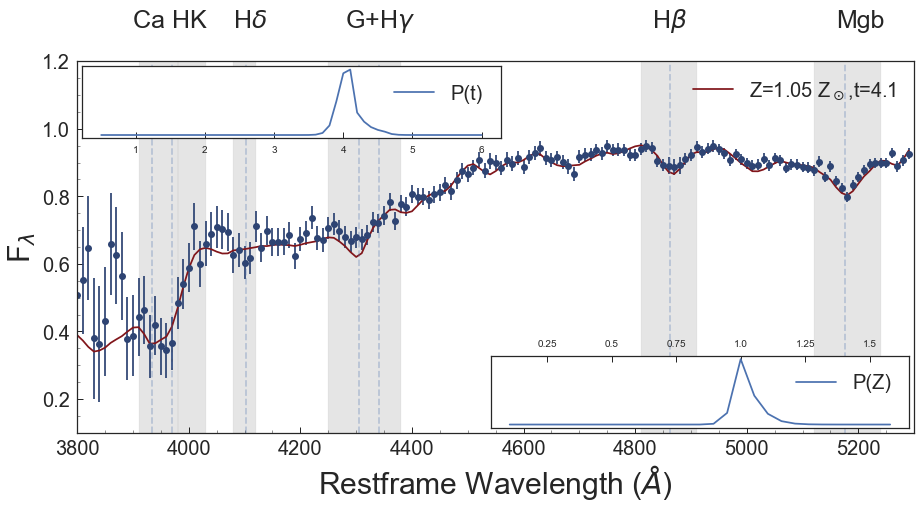

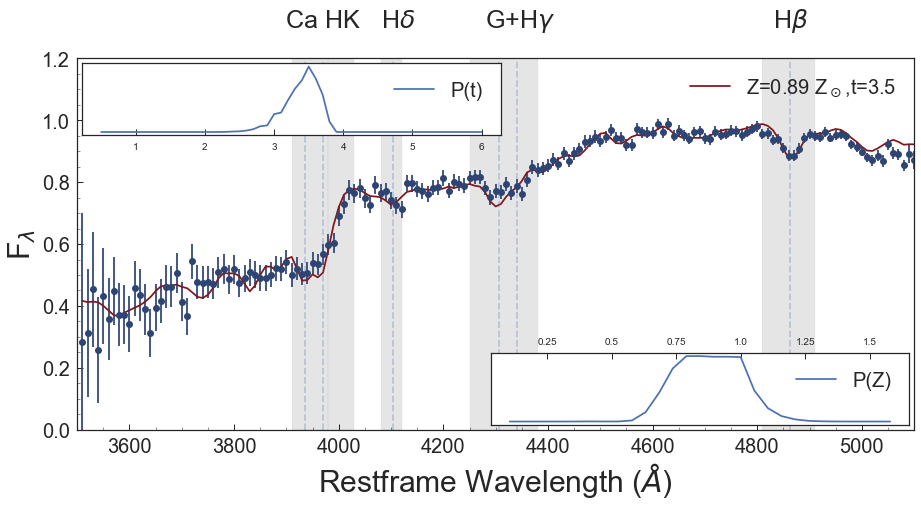

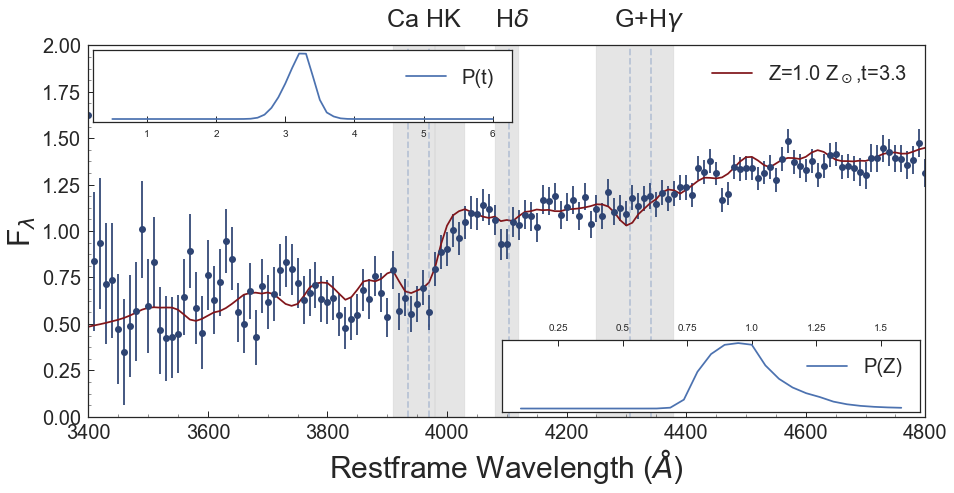

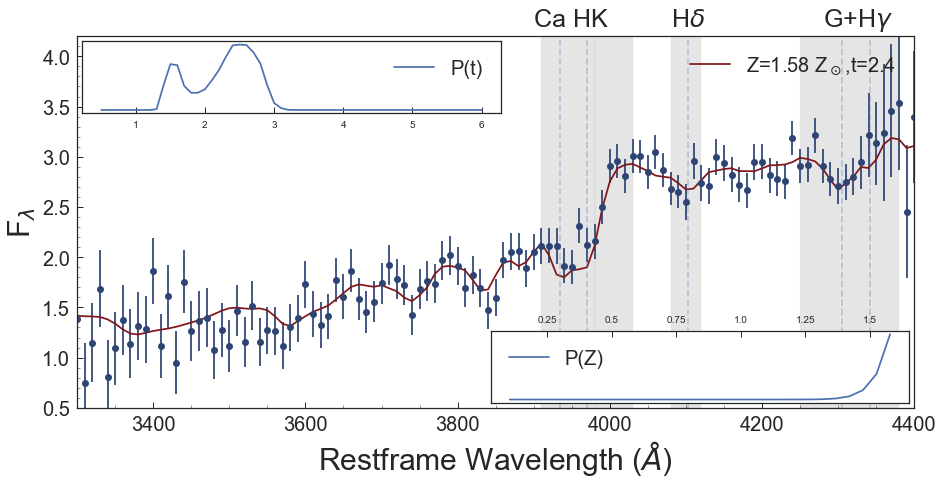

In [29]:
%matplotlib inline

Plot_stack(lzstack.wv,lzstack.fl,lzstack.er,lzstack.mwv,lzstack.mfl,0.02,4.1,PTl,PZl,
           window=[3800,5300,.1,1.2],save_plot=False,plot_name='../plots/stack_lz_bf_6-29.png')

Plot_stack(mzstack.wv,mzstack.fl,mzstack.er,mzstack.mwv,mzstack.mfl,0.017,3.5,PTm,PZm,
           window=[3500,5100,0,1.2],save_plot=False,plot_name='../plots/stack_mz_bf_7-2.png')

Plot_stack(hzstack.wv,hzstack.fl,hzstack.er,hzstack.mwv,hzstack.mfl,0.019,3.3,PTh,PZh,
           window=[3400,4800,0,2],save_plot=False,plot_name='../plots/stack_hz_bf_6-29.png')

Plot_stack(uhzstack.wv,uhzstack.fl,uhzstack.er,uhzstack.mwv,uhzstack.mfl,0.03,2.4,PTuh,PZuh,
           window=[3300,4400,0.5,4.2],save_plot=False,plot_name='../plots/stack_uhz_bf_6-29.png')

#Fitting Technique Compare

In [3]:
"""DATA"""
mlist,alist = np.load('../mcerr/simgal_m0.015_a3.0_z1.1_mcerr.npy')
ncmlist,ncalist = np.load('../mcerr/simgal_m0.015_a3.0_z1.1_nc_mcerr.npy')
tmlist,talist = np.load('../mcerr/simgal_m0.015_a3.0_z1.1_t_mcerr.npy')

In [11]:
"""PLOT"""
%matplotlib inline

plt.figure(figsize=[10,8])
plt.axvline(0.015/.019,color='k',alpha=.4,linestyle='-.',label = 'True value')
sea.distplot(mlist/.019,label='double fitting')
sea.distplot(ncmlist/.019,label='no continuum')
sea.distplot(tmlist/.019,label='with continuum')
plt.xlim(0,1.5)
plt.xlabel('Metallicity (Z/Z$_\odot$)',fontsize = 30)
plt.ylabel('P(Z)',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(loc=1,fontsize=23)
plt.minorticks_on()
# plt.show()
plt.savefig('../plots/P-z_3cases.png')
plt.close()

plt.figure(figsize=[10,8])
plt.axvline(3.0,color='k',alpha=.4,linestyle='-.',label = 'True value')
sea.distplot(alist,label='double fitting')
sea.distplot(ncalist,label='no continuum')
sea.distplot(talist,label='with continuum')
plt.xlim(0,6)
plt.xlabel('Age (Gyr)',fontsize = 30)
plt.ylabel('P(t)',fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.gcf().subplots_adjust(bottom=0.235)
plt.legend(loc=2,fontsize=23)
plt.minorticks_on()
# plt.show()
plt.savefig('../plots/P-t_3cases.png')
plt.close()

#Fitting Technique Compare - Likelihoods

In [10]:
"""PLOTS""" # same data as above
# %maplotlib inline
colmap = sea.cubehelix_palette(12, start=3, rot=0.5, dark=0.1, light=.5, as_cmap=True)

Mlist =np.array([mlist,ncmlist,tmlist])
Alist = np.array([alist,ncalist,talist])
pltnames = ['used_LH.png','nc_LH.png','t_LH.png']

for i in range(len(Mlist)):
    plt.figure(figsize=[10,8])
    plt.plot(Mlist[i]/.019,Alist[i],'o',alpha=.3,ms=4)
    sea.kdeplot(Mlist[i]/.019,Alist[i],n_levels=3,cmap=colmap)
    plt.plot(0.015/.019,3.0,'rp',label='Given parameters')
    plt.axis([0.0/.019,.03/.019,0,6])
    plt.xlabel('Metallicity (Z/Z$_\odot$)',fontsize = 30)
    plt.ylabel('Age (Gyr)',fontsize = 30)
    # plt.title('Continuum',fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=23)
    plt.legend(loc=4,fontsize=23)
    plt.minorticks_on()
    # plt.show()
    plt.savefig('../plots/' + pltnames[i])
    plt.close()

In [18]:
%matplotlib inline

Pr,hexa,hexm=Analyze_Stack_avgage('chidat/gt10.93_jan17_3250-5350_fit_chidata.fits', np.array(tau),metal,age)
mh=[np.trapz(U,age) for U in Pr.T]
hel,heh= Error(mh,metal)
print hel,heh
print hel/0.019,heh/0.019
print np.trapz(np.multiply(mh,metal),metal)/0.019


Pr,lexa,lexm=Analyze_Stack_avgage('chidat/lt10.93_jan17_3250-5350_fit_chidata.fits', np.array(tau),metal,age)
ml=[np.trapz(U,age) for U in Pr.T]
lel, leh=Error(ml,metal)
print lel,leh
print lel/0.019,leh/0.019
print np.trapz(np.multiply(mh,metal),metal)/0.019

print min(lmass[IDL]),max(lmass[IDL])
print min(lmass[IDH]),max(lmass[IDH])

logm,gmetal=Readfile('Gallazzi_12.dat',0)
cvx,cvy=Readfile('Gallazzi_12_line.dat',0)
cv1x,cv1y=Readfile('gallazzi_points_curve1.dat',0)

glist,sgm,sgler,sgher,sgmass=Readfile('sg_fit_metals.dat',is_float=False)
sgm,sgler,sgher,sgmass=np.array([sgm,sgler,sgher,sgmass]).astype(float)

IOError: [Errno 2] No such file or directory: 'chidat/gt10.93_jan17_3250-5350_fit_chidata.fits'

In [ ]:
plt.figure(figsize=[8,8])
currentAxis = plt.gca()
##<10.9
lm=plt.errorbar(10.5,np.log10(lexm/.019),xerr=[[.415],[.415]],yerr=np.abs([[np.log10(lexm/lel)],
    [np.log10(lexm/leh)]]),zorder=5,color='#124FD2',ms=1,label='log($M_*/M_\odot$)<10.87')

###>10.9
hm=plt.errorbar(11.075,np.log10(hexm/.019),xerr=[[.135],[.135]],yerr=np.abs([[np.log10(hexm/hel)],
    [np.log10(hexm/heh)]]),zorder=5,color='#E40081',ms=1,label='log($M_*/M_\odot$)>10.87')

####gallazzi points
plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.5, label='SDSS')
sdss=plt.axhline(y=5,linestyle='--',color='k',alpha=.5)
plt.plot(cvx,cvy,zorder=2,color='k',alpha=.5, label='Gallazzi+14 best fit line')
galbf=plt.axhline(y=5,color='k',alpha=.5)
gal=plt.scatter(logm,gmetal,zorder=3,color=sea.color_palette('muted')[4],label='Gallazzi+14,z=0.7')

#####single galaxy points
sg=plt.errorbar(sgmass,np.log10(sgm/0.019),yerr=np.abs([np.log10(sgm/sgler),np.log10(sgm/sgher)]),
                color='#31EA00', fmt='s', ms=5)

plt.legend([lm,hm,sg,gal,galbf,sdss],['log($M_*/M_\odot$)<10.87','log($M_*/M_\odot$)>10.87', 'Individual CLEAR galaxies',
                                    'Gallazzi+14,z=0.7','Gallazzi+14 best fit line','SDSS'],loc=3,fontsize=15)
plt.xlabel('log(M/M$_\odot$)',size=20)
plt.ylabel('log(Z/Z$_\odot$)',size=20)
plt.axis([10,11.8,-1.5,.5])
plt.tick_params(axis='both', which='major', labelsize=17)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
# plt.show()
plt.savefig('../important_plots/massvmetal_1-18.png')
plt.close()

In [ ]:
Pr,exa,exm=Analyze_Stack_avgage('chidat/gt10.93_feb23_fit_chidata.fits', np.array(tau),metal,age)
# onesig,twosig=Likelihood_contours(age,metal,Pr)
# levels=np.array([twosig,onesig])
# print levels

a=[np.trapz(U,metal) for U in Pr]
m=np.array([np.trapz(U,age) for U in Pr.T])/0.019

gs=gridspec.GridSpec(2,2,width_ratios=[3,1],height_ratios=[1,4])

levels=np.array([22.90946612, 274.30537752])

plt.figure(figsize=[8,8])
gs.update(wspace=0.0,hspace=0.0)
ax=plt.subplot(gs[1,0])
plt.contour(M,A,Pr,levels,colors='k',linewidths=2)
plt.contourf(M,A,Pr,40,cmap=cmap)
plt.xlabel('Z/Z$_\odot$',size=20)
plt.ylabel('Average Age (Gyrs)',size=20)
plt.plot(exm/0.019,exa,'d',color='#81161B',ms=6,
            label='log($M_*/M_\odot$)>10.93\nBest fit\nt=%s Gyrs\nZ=%s Z$_\odot$' %
                  (exa,np.round(exm/0.019,2)))
plt.legend(loc=3,fontsize=17)
# plt.xticks([0.0095, 0.01425, 0.019, 0.2375, 0.285],
#            np.round(np.array([0.0095, 0.01425, 0.019, 0.2375, 0.285])/0.019, 2))

# plt.xticks([0.0095, 0.01425, 0.019, 0.2375, 0.285],
#            [.5,.75,1.0,1.25,1.5])
plt.minorticks_on()
plt.xlim(.5,1.5)
plt.ylim(1,4.4)
plt.tick_params(axis='both', which='major', labelsize=17)

plt.subplot(gs[1,1])
plt.plot(a,age)
plt.ylim(1,4.4)
plt.yticks([])
plt.xticks([])
#
plt.subplot(gs[0,0])
plt.plot(metal/0.019,m)
plt.xlim(.5,1.5)
plt.yticks([])
plt.xticks([])
plt.gcf().subplots_adjust(bottom=0.165,left=0.12)
# plt.show()
plt.savefig('../important_plots/gt10-93_LH_2-23.png')
plt.close()

####
#Lowmass
####
# 
Pr,exa,exm=Analyze_Stack_avgage('chidat/lt10.93_feb23_fit_chidata.fits', np.array(tau),metal,age)
# onesig,twosig=Likelihood_contours(age,metal,Pr)
# levels=np.array([twosig,onesig])
# print levels

a=[np.trapz(U,metal) for U in Pr]
m=np.array([np.trapz(U,age) for U in Pr.T])/0.019

gs=gridspec.GridSpec(2,2,width_ratios=[3,1],height_ratios=[1,4])

levels=np.array([ 23.75864788, 116.41737463])

plt.figure(figsize=[8,8])
gs.update(wspace=0.0,hspace=0.0)
ax=plt.subplot(gs[1,0])
plt.contour(M,A,Pr,levels,colors='k',linewidths=2)
plt.contourf(M,A,Pr,40,cmap=cmap)
plt.xlabel('Z/Z$_\odot$',size=20)
plt.ylabel('Average Age (Gyrs)',size=20)
plt.plot(exm/0.019,exa,'d',color='#81161B',ms=6,
            label='log($M_*/M_\odot$)<10.93\nBest fit\nt=%s Gyrs\nZ=%s Z$_\odot$' %
                  (exa,np.round(exm/0.019,2)))
plt.legend(loc=2,fontsize=17)
# plt.xticks([0,0.00475,0.0095,0.01425,.019,0.2375,0.285]
#            ,np.round(np.array([0,0.00475,0.0095,0.01425,.019,0.2375,0.285])/0.019,2))
plt.minorticks_on()
plt.xlim(.5,1.5)
plt.ylim(1,4.4)
plt.tick_params(axis='both', which='major', labelsize=17)

plt.subplot(gs[1,1])
plt.plot(a,age)
plt.ylim(1,4.4)
plt.yticks([])
plt.xticks([])
#
plt.subplot(gs[0,0])
plt.plot(metal/0.019,m)
plt.xlim(.5,1.5)
plt.yticks([])
plt.xticks([])
plt.gcf().subplots_adjust(bottom=0.165,left=0.12)
# plt.show()
plt.savefig('../important_plots/lt10-93_LH_2-23.png')
plt.close()

In [ ]:
Pr,hexa,hexm=Analyze_Stack_avgage('chidat/gt10.93_jan17_3250-5350_fit_chidata.fits', np.array(tau),metal,age)
ah=[np.trapz(U,metal) for U in Pr]
hel,heh= Error(ah,age)
print hel,heh
print np.trapz(np.multiply(ah,age),age)

Pr,lexa,lexm=Analyze_Stack_avgage('chidat/lt10.93_jan17_3250-5350_fit_chidata.fits', np.array(tau),metal,age)
al=[np.trapz(U,metal) for U in Pr]
lel, leh=Error(al,age)
print lel,leh
print np.trapz(np.multiply(al,age),age)


print min(rshift[IDL]),max(rshift[IDL]), np.mean(rshift[IDL])
print min(rshift[IDH]),max(rshift[IDH]), np.mean(rshift[IDH])

fumx,fumy=Readfile('fumagalli_fig14.dat',0)
d,fverr=Readfile('fumagalli_fig14_verr.dat',0)
fherr,d=Readfile('fumagalli_fig14_herr.dat',0)
z=np.linspace(0,2,100)
ages=[Oldest_galaxy(a) for a in z]

verr=np.zeros(len(fverr))
herr=np.zeros(len(fherr))
for i in range(len(verr)):
    verr[i]=np.abs(fverr[i]-fumy[i])
    herr[i]=np.abs(fherr[i]-fumx[i])
    
glist,sga,sgaler,sgaher,sgrshift=Readfile('sg_fit_ages.dat',is_float=False)
sga,sgaler,sgaher,sgrshift=np.array([sga,sgaler,sgaher,sgrshift]).astype(float)

In [ ]:
%matplotlib inline

plt.figure(figsize=[12,8])
currentAxis = plt.gca()

plt.plot(z,ages,'k--',alpha=.5)
# #########fsps
# ####ls10.87
# lme=plt.errorbar(1.3215,lexa,xerr=.015,yerr=[[lexa-lel],[leh-lexa]]
#              ,color='w',zorder=5,fmt='s',ms=.1,label='log($M_*/M_\odot$)<10.93')

lme=plt.scatter(1.3215,lexa,
             color='w',zorder=5,marker='s',label='log($M_*/M_\odot$)<10.93')

lm=currentAxis.add_patch(Rectangle((min(rshift[IDL]),lel),max(rshift[IDL])-min(rshift[IDL]),leh-lel
                                ,color='#124FD2',zorder=4,alpha=1))
####gt10.87
# hme=plt.errorbar(1.32,hexa,xerr=.015,yerr=[[hexa-hel],[heh-hexa]]
#              ,color='w',zorder=5,fmt='s',ms=.1,label='log($M_*/M_\odot$)>10.93')

hme=plt.scatter(1.32,hexa,color='w',zorder=5,marker='s',
                label='log($M_*/M_\odot$)>10.93')

hm=currentAxis.add_patch(Rectangle((min(rshift[IDH]),hel),max(rshift[IDH])-min(rshift[IDH]),heh-hel
                                ,color='#E40081',zorder=4,alpha=1))
##########other point
fumbc=plt.errorbar(fumx[0:3],fumy[0:3],xerr=herr[0:3],yerr=verr[0:3]
             ,color='#8E9AB3',zorder=1,fmt='o',alpha=1,ms=1)#,label='Fumagalli+16 BC03')
fumfs=plt.errorbar(fumx[3:6],fumy[3:6],xerr=herr[3:6],yerr=verr[3:6]
             ,color='#DDF0B8',zorder=1,fmt='o',alpha=1,ms=1)#,label='Fumagalli+16 FSPS10')
fumck=plt.errorbar(fumx[6:9],fumy[6:9],xerr=herr[6:9],yerr=verr[6:9]
             ,color='#FFEBC4',zorder=1,fmt='o',alpha=1,ms=1)#,label='Fumagalli+16 FSPSC3K')
men=plt.scatter(fumx[9],fumy[9],color='k',marker='^',zorder=2)#,label='Mendel+15')
choi=plt.scatter(fumx[10:14],fumy[10:14],color='k',marker='p',zorder=2)#,label='Choi+14')
gal=plt.scatter(fumx[14],fumy[14],color='k',marker='d',zorder=2)#,label='Gallazzi+14')
whit=plt.scatter(fumx[15],fumy[15],color='k',marker='*',zorder=2)#,label='Whitaker+13')
plt.axis([0,2,0,8])

####single galaxy
# sgavr=plt.errorbar(sgrshift,sga,yerr=[np.abs(sga-sgaler),np.abs(sga-sgaher)], color='#31EA00',
#              alpha=1, zorder=6,fmt='s', ms=5)


l1=plt.legend([men,choi,gal,whit,fumbc,fumfs,fumck],['Mendel+15','Choi+14','Gallazzi+14','Whitaker+13',
                                                     'Fumagalli+16 BC03','Fumagalli+16 FSPS10','Fumagalli+16 FSPSC3K'],
                                                        loc=3,fontsize=10)
# plt.legend([(lm,lme),(hm,hme),sgavr],['log($M_*/M_\odot$)<10.87','log($M_*/M_\odot$)>10.87','Individual CLEAR galaxies'],
#                                                         loc=1,fontsize=14)

plt.legend([(lm,lme),(hm,hme)],['log($M_*/M_\odot$)<10.87','log($M_*/M_\odot$)>10.87'],
                                                        loc=1,fontsize=14)

plt.gca().add_artist(l1)
plt.xlabel('Redshift',size=20)
plt.ylabel('Age (Gyrs)',size=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.minorticks_on()
plt.text(1,6.35,'Age of the Universe',rotation=-29,fontsize=12)
plt.gcf().subplots_adjust(bottom=0.16)
# plt.show()
# plt.savefig('../important_plots/agevred_1-18.png')
plt.savefig('../important_plots/agevred_nosg_1-19.png')
plt.close()

In [ ]:
dat=fits.open('../../../Clear_data/extractions_nov_22/GS3/GS3-G102_40597.2D.fits')
wv,fl,er=np.array(Readfile('spec_stacks_nov29/s40597_stack.dat'))

sens=dat[10].data
wave=dat[9].data
isens=interp1d(wave,sens)
newsens=isens(wv)
newsens/=max(newsens)

cmap = sea.cubehelix_palette(12, start=2, rot=.5, dark=0, light=1.1, as_cmap=True)
gs=gridspec.GridSpec(2,1,height_ratios=[1,5],hspace=0)
########
plt.figure(figsize=(15,5))
plt.subplot(gs[0])
plt.imshow(dat[5].data-dat[8].data,cmap=cmap, aspect='auto')
plt.xticks([],[])
plt.yticks([],[])
##########
plt.subplot(gs[1])
plt.errorbar(wv,newsens*fl/1E-18,newsens*er/1E-18,color='#465885',ecolor='#a4699f',
             fmt='o',ms=3,label='GS3-G102_40597\nz=1.22')
plt.axvspan(3910*2.22, 3979*2.22, color='k', alpha=.1,zorder=0)
plt.axvspan(3981*2.22, 4030*2.22, color='k', alpha=.1,zorder=0)
plt.axvspan(4082*2.22, 4122*2.22, color='k', alpha=.1,zorder=0)
plt.axvspan(4250*2.22, 4400*2.22, color='k', alpha=.1,zorder=0)
plt.axvspan(4830*2.22, 4930*2.22, color='k', alpha=.1,zorder=0)
plt.axvspan(5109*2.22, 5250*2.22, color='k', alpha=.1,zorder=0)
plt.text(3890*2.22,2.25,'Ca HK',fontsize=18)
plt.text(4080*2.22,2.25,'H$\delta$',fontsize=18)
plt.text(4275*2.22,2.25,'H$\gamma$+G',fontsize=18)
plt.text(4860*2.22,2.25,'H$\\beta$',fontsize=18)
plt.text(5160*2.22,2.25,'Mg',fontsize=18)
plt.ylim(0,3.5)
plt.xlim(wave[0],wave[-1])
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\AA$)',size=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc=2,fontsize=15)
plt.xlabel('Wavelength ($\AA$)',size=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.gcf().subplots_adjust(bottom=0.2 )
plt.minorticks_on()
plt.show()
# plt.savefig('../important_plots/1d2dspec_40597_1-18.png')
plt.close()

######################

dat=fits.open('../../../Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-G102_39170.2D.fits')
wv,fl,er=np.array(Readfile('spec_stacks_nov29/s39170_stack.dat'))

sens=dat[10].data
wave=dat[9].data
isens=interp1d(wave,sens)
newsens=isens(wv)
newsens/=max(newsens)

cmap = sea.cubehelix_palette(12, start=2, rot=.5, dark=0, light=1.1, as_cmap=True)
gs=gridspec.GridSpec(2,1,height_ratios=[1,5],hspace=0)
########
plt.figure(figsize=(15,5))
plt.subplot(gs[0])
plt.imshow(dat[5].data-dat[8].data,cmap=cmap, aspect='auto')
plt.xticks([],[])
plt.yticks([],[])
##########
plt.subplot(gs[1])
plt.errorbar(wv,newsens*fl/1E-18,newsens*er/1E-18,color='#465885',ecolor='#a4699f',
             fmt='o',ms=3,label='ERSPRIME-G102_39170\nz=1.022')
plt.axvspan(3910*2.022, 3979*2.022, color='k', alpha=.1,zorder=0)
plt.axvspan(3981*2.022, 4030*2.022, color='k', alpha=.1,zorder=0)
plt.axvspan(4082*2.022, 4122*2.022, color='k', alpha=.1,zorder=0)
plt.axvspan(4250*2.022, 4400*2.022, color='k', alpha=.1,zorder=0)
plt.axvspan(4830*2.022, 4930*2.022, color='k', alpha=.1,zorder=0)
plt.axvspan(5109*2.022, 5250*2.022, color='k', alpha=.1,zorder=0)
plt.text(3890*2.022,2.25,'Ca HK',fontsize=18)
plt.text(4080*2.022,2.25,'H$\delta$',fontsize=18)
plt.text(4270*2.022,2.25,'H$\gamma$+G',fontsize=18)
plt.text(4850*2.022,2.25,'H$\\beta$',fontsize=18)
plt.text(5160*2.022,2.25,'Mg',fontsize=18)
plt.ylim(0,5.2)
plt.xlim(wave[0],wave[-1])
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\AA$)',size=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc=2,fontsize=15)
plt.xlabel('Wavelength ($\AA$)',size=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.gcf().subplots_adjust(bottom=0.2)
plt.minorticks_on()
plt.show()
# plt.savefig('../important_plots/1d2dspec_39170_1-18.png')
plt.close()

In [ ]:
plt.figure(figsize=[8,8])
plt.hist(lmass[IDA],12)
plt.axvline(10.93,color='k',alpha=.5,linestyle='--')
plt.xlabel('log(M/M$_\odot$)',size=20)
plt.ylabel('N',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.18)
# plt.show()
plt.savefig('../important_plots/mass_hist_1-18.png')
plt.close()
 
plt.figure(figsize=[8,8])
plt.hist(rshift[IDA],12)
plt.xlabel('Redshift',size=20)
plt.ylabel('N',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.18)
# plt.show()
plt.savefig('../important_plots/redshift_hist_1-18.png')
plt.close()

In [ ]:
%matplotlib inline

mclist=glob('mcerr/mcom*')

def Get_repeats(x,y):
    z=[x,y]
    tz=np.transpose(z)
    size=np.zeros(len(tz))
    for i in range(len(size)):
        size[i]=len(np.argwhere(tz==tz[i]))/2
    size/=5
    return size

def Get_entry_size(param):
    plist = np.unique(param)
    size=np.zeros(len(plist))
    for i in range(len(plist)):
        size[i]=len(param[param == plist[i]])
    return plist,size

def Get_merr_1sig(uni,size):
    psum=[]
    for i in range(len(size)):
        psum.append(size[i])
        if sum(psum) >= 160:
            break
        
    psum2=[]
    for i in range(len(size)):
        psum2.append(size[::-1][i])
        if sum(psum2) >= 160:
            break
    return uni[len(psum)-1],uni[-(len(psum2)-1)]
        
params=[[0.0085,2.0],[0.0132,4.3],[0.019,3.1],[0.024,3.5],[0.0085,2.0],[0.0132,4.3],[0.019,3.1],[0.024,3.5]]
fn=['c','c','c','c','nc','nc','nc','nc']
location=[1,4,3,3,4,4,3,3]
for i in range(len(mclist)):
    
    # print mclist[i]
    merr,aerr=Readfile(mclist[i])
    s = Get_repeats(merr, aerr)
    muni, msize = Get_entry_size(merr)
    auni, asize = Get_entry_size(aerr)
    lm,hm = Get_merr_1sig(muni,msize)
    la,ha = Get_merr_1sig(auni,asize)

    gs=gridspec.GridSpec(2,2,width_ratios=[3,1],height_ratios=[1,4])

    plt.figure(figsize=[8,8])
    gs.update(wspace=0.0,hspace=0.0)
    ax=plt.subplot(gs[1,0])
    plt.scatter(merr, aerr, s=s,label='MC points')
    plt.plot(params[i][0],params[i][1], 'rd',label='Model')
    # plt.axvline(muni[np.argmax(msize)],color='#f6a300',linestyle='-.',label='Mode')
    plt.plot(muni[np.argmax(msize)],auni[np.argmax(asize)],'p',color='#f6a300',label='Mode')
    plt.axvline(lm,color='k',linestyle='--',alpha=.5,label='1 $\sigma$')
    plt.axvline(hm,color='k',linestyle='--',alpha=.5)
    # plt.axhline(auni[np.argmax(asize)],color='r',linestyle='-.')
    plt.axhline(la,color='k',linestyle='--',alpha=.5)
    plt.axhline(ha,color='k',linestyle='--',alpha=.5)
    plt.ylim(0,6)
    plt.xlim(0,0.03)
    plt.xticks([0.00475,0.0095, 0.01425, 0.019, 0.02375, 0.0285],
           np.round(np.array([0.00475,0.0095, 0.01425, 0.019, 0.02375, 0.0285])/0.019, 2))
    plt.minorticks_on()
    plt.tick_params(axis='both', which='major', labelsize=17)
    plt.xlabel('Z/Z$_\odot$',size=20)
    plt.ylabel('Average Age (Gyrs)',size=20)
    plt.legend(loc=location[i],fontsize=15)


    plt.subplot(gs[1,1])
    plt.hist(aerr,50,orientation='horizontal')
    # plt.axhline(auni[np.argmax(asize)],color='r',linestyle='-.')
    plt.axhline(la,color='k',linestyle='--',alpha=.5)
    plt.axhline(ha,color='k',linestyle='--',alpha=.5)
    plt.ylim(0,6)
    plt.yticks([])
    plt.xticks([])

    plt.subplot(gs[0,0])
    plt.hist(merr,25)
    # plt.axvline(muni[np.argmax(msize)],color='r',linestyle='-.')
    plt.axvline(lm,color='k',linestyle='--',alpha=.5)
    plt.axvline(hm,color='k',linestyle='--',alpha=.5)
    plt.xlim(0,.03)
    plt.yticks([])
    plt.xticks([])
    plt.gcf().subplots_adjust(bottom=0.165,left=0.12)
    # plt.show()
    plt.savefig('../mcerr_plots/mcerr_dist_%s_%s_%s.png' % (fn[i],params[i][0],params[i][1]))
    plt.close()

In [16]:
%matplotlib inline

img1=fits.open('../../../Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-19-122-G102_39170.2D.fits')
img2=fits.open('../../../Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-21-092-G102_39170.2D.fits')
img3=fits.open('../../../Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-22-142-G102_39170.2D.fits')

print img1.info()

Filename: ../../../Clear_data/extractions_nov_22/ERSPRIME/ERSPRIME-19-122-G102_39170.2D.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      36   ()              
1    DSCI        ImageHDU        51   (36, 36)     float64   
2    DINTER      ImageHDU        51   (36, 36)     float64   
3    DWHT        ImageHDU        51   (36, 36)     float32   
4    DSEG        ImageHDU        51   (36, 36)     int32   
5    SCI         ImageHDU        52   (360, 36)    float64   
6    WHT         ImageHDU        53   (360, 36)    float64   
7    MODEL       ImageHDU        53   (360, 36)    float64   
8    CONTAM      ImageHDU        53   (360, 36)    float64   
9    WAVE        ImageHDU        52   (360,)       float64   
10   SENS        ImageHDU        53   (360,)       float64   
11   YTRACE      ImageHDU        53   (360,)       float64   


None


In [3]:
field = fits.open('../../Grizlsim/s39170_cmb_flt.fits')

In [4]:
field.info()

Filename: ../../Grizlsim/s39170_cmb_flt.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     282   ()              
1    SCI         ImageHDU        58   (1614, 1614)   float32   
2    ERR         ImageHDU        58   (1614, 1614)   float32   
3    DQ          ImageHDU        58   (1614, 1614)   int64   


In [67]:
%matplotlib inline

gs = gridspec.GridSpec(1,2,width_ratios=[1,7.5],wspace=0)

plt.figure(figsize=[12,4])
# plt.subplot(gs[0])
# plt.imshow(img1['DSCI'].data[::-1])
# plt.yticks([])
# plt.xticks([])
# 
# plt.subplot(gs[1])
plt.imshow((img1['SCI'].data)[::-1,60:330])
plt.yticks([])
plt.xticks([])
plt.savefig('../plots/s39170_p1.png')
# plt.show()
plt.close()

plt.figure(figsize=[12,4])
# plt.subplot(gs[0])
# plt.imshow(img2['DSCI'].data[::-1])
# plt.yticks([])
# plt.xticks([])
# 
# plt.subplot(gs[1])
plt.imshow((img2['SCI'].data)[::-1,60:330])
plt.yticks([])
plt.xticks([])
plt.savefig('../plots/s39170_p2.png')
# plt.show()
plt.close()

plt.figure(figsize=[12,4])
# plt.subplot(gs[0])
# plt.imshow(img3['DSCI'].data[::-1])
# plt.yticks([])
# plt.xticks([])
# 
# plt.subplot(gs[1])
plt.imshow((img3['SCI'].data)[::-1,60:330])
plt.yticks([])
plt.xticks([])
plt.savefig('../plots/s39170_p3.png')
# plt.show()
plt.close()